In [87]:
import pandas as pd

# C Kernel Results:
1. Function: refers to the function tested in that iteration
2. Dimension: the number of dimensions in the function
3. Loop: the current iteration of testing for that function
4. Time Taken: the number of milliseconds it took to finish that iteration
5. Fitness: the best fitness found in that iteration

In [88]:
results_c_df = pd.read_csv('result_c.csv')

# Rename Function to words (0 = Sphere, 1 = Ackley, 2 = Rosenbrock) for easier recognition
func_map = {0: "Sphere", 1: "Ackley", 2: "Rosenbrock"}
results_c_df["Function"] = results_c_df["Function"].astype(int).map(func_map)

results_c_df

,Function,Dimension,Loop,Time Taken,Fitness
0,Sphere,4,0,31.889,0.000000
1,Sphere,4,1,32.744,0.000000
2,Sphere,4,2,32.297,0.000000
3,Sphere,4,3,32.593,0.000000
4,Sphere,4,4,31.550,0.000000
...,...,...,...,...,...
265,Rosenbrock,1024,25,921153.309,85.459360
266,Rosenbrock,1024,26,980926.273,81.220970
267,Rosenbrock,1024,27,990032.511,75.296377
268,Rosenbrock,1024,28,932351.978,86.868092


Below are the cells used to compute for the Average Time taken of each C function

In [89]:
average_time_df = results_c_df.groupby(["Function", "Dimension"], as_index=False)["Time Taken"].mean()
average_time_df.rename(columns={"Time Taken": "Average Time Taken"}, inplace=True)
average_time_df

,Function,Dimension,Average Time Taken
0,Ackley,4,5.362013e+01
1,Ackley,256,1.027805e+05
2,Ackley,1024,1.411232e+06
3,Rosenbrock,4,3.157270e+01
4,Rosenbrock,256,5.587193e+04
5,Rosenbrock,1024,9.376103e+05
6,Sphere,4,2.816757e+01
7,Sphere,256,2.804912e+04
8,Sphere,1024,4.254139e+05


In [90]:
average_time_df.to_csv('C_avg_times.csv', index=False)

# CUDA Kernel Results:
1. Function: refers to the function tested in that iteration
2. Dimension: the number of dimensions in the function
3. Loop: the current iteration of testing for that function
4. Fitness: the best fitness found in that iteration

NOTE: The time taken for CUDA kernels has to be calculated manually by observing NSYS results

In [91]:
results_cuda_df = pd.read_csv('result_cuda.csv')
results_cuda_df

,Function,Dimension,Loop,Fitness
0,Sphere,4,0,0.000000
1,Sphere,4,1,0.000000
2,Sphere,4,2,0.000000
3,Sphere,4,3,0.000000
4,Sphere,4,4,0.000000
...,...,...,...,...
355,Rosenbrock,8192,25,1541.642641
356,Rosenbrock,8192,26,4194.227511
357,Rosenbrock,8192,27,2183.262175
358,Rosenbrock,8192,28,1955.522865


In [92]:
cuda_avg_times_df = pd.read_csv('CUDA_avg_times.csv')
cuda_avg_times_df

,Function,Dimension,TotalTime_SEC,AvgTime_MS
0,Ackley,4,5.16031,172.010
1,Ackley,256,12.39510,413.170
2,Ackley,1024,28.07700,935.900
3,Ackley,8192,924.89100,30829.700
4,Rosenbrock,4,4.68398,156.133
5,Rosenbrock,256,10.41010,347.003
6,Rosenbrock,1024,17.45340,581.780
7,Rosenbrock,8192,359.42500,11980.833
8,Sphere,4,5.26255,175.418
9,Sphere,256,9.43835,314.612


In [93]:
cuda_avg_times_df = cuda_avg_times_df.drop(columns=["TotalTime_SEC"]).rename(columns={"AvgTime_MS": "Average Time Taken"})
cuda_avg_times_df

,Function,Dimension,Average Time Taken
0,Ackley,4,172.010
1,Ackley,256,413.170
2,Ackley,1024,935.900
3,Ackley,8192,30829.700
4,Rosenbrock,4,156.133
5,Rosenbrock,256,347.003
6,Rosenbrock,1024,581.780
7,Rosenbrock,8192,11980.833
8,Sphere,4,175.418
9,Sphere,256,314.612


# Correctness comparison

This section aims to evaluate the correctness of both the CUDA and C implementations of the CPSO-S Algorithm. Since the algorithm has some inherent randomness, its solutions would sometimes be different. This would mean that each iteration might have a different solution or fitness, despite having the exact same configuration, making it hard to consistently reach the **absolutely** correct answer. Given this, we would be considering the fitness/solution of the iteration to be correct if it is lower than a certain threshold (0.25 in this case).

The configuration of the algorithm runs (CUDA and C are identical) are as follows:
- **particles** - 100
- **iterations** - 500 (iterations of a single CPSO run)
- **loops** - 30 (how many times the algorithm was ran)

Three functions were used for evaluation, alongside their minimal value and their positions.
1. Sphere: f(x) = 0 with domain x = (0, 0, ...,0)
2. Ackley: f(x) = 0 with domain x = (0, 0, 0, ..., 0)
3. Rosenbrock: f(x) = 0 with domain x = (1, 1, ..., 1)

Overall, it can be observed that both implementations had similar correctness.

It can also be observed that the CPSO-S algorithm consistently converges to a near-optimum solution when using the Ackley and Sphere functions, regardless of the increase in dimensions.

However, in using the Rosenbrock function, it could be observed that it has a hard time converging to a near-optimum solution and it worsens with more dimensions with it not having any "correct" solutions past 4-dimensions.


In [94]:
def count_correct(df, tolerance = 0.25):
  group = df.groupby(["Function", "Dimension"])["Fitness"]
  out = group.agg(count=lambda s: (s <= tolerance).sum(),
                  mean=lambda s: (s <= tolerance).mean()).reset_index()
  out = out.rename(columns={"count": "Correctness Count", "mean": "Correctness Mean"})
  out["tolerance"] = tolerance
  return out.sort_values(["Function", "Dimension"])

In [95]:
count_correct(results_c_df)

,Function,Dimension,Correctness Count,Correctness Mean,tolerance
0,Ackley,4,28,0.933333,0.25
1,Ackley,256,30,1.000000,0.25
2,Ackley,1024,30,1.000000,0.25
3,Rosenbrock,4,15,0.500000,0.25
4,Rosenbrock,256,0,0.000000,0.25
5,Rosenbrock,1024,0,0.000000,0.25
6,Sphere,4,30,1.000000,0.25
7,Sphere,256,30,1.000000,0.25
8,Sphere,1024,30,1.000000,0.25


In [96]:
count_correct(results_cuda_df)

,Function,Dimension,Correctness Count,Correctness Mean,tolerance
0,Ackley,4,30,1.000000,0.25
1,Ackley,256,30,1.000000,0.25
2,Ackley,1024,30,1.000000,0.25
3,Ackley,8192,30,1.000000,0.25
4,Rosenbrock,4,16,0.533333,0.25
5,Rosenbrock,256,0,0.000000,0.25
6,Rosenbrock,1024,0,0.000000,0.25
7,Rosenbrock,8192,0,0.000000,0.25
8,Sphere,4,30,1.000000,0.25
9,Sphere,256,30,1.000000,0.25


# Speed Comparison
The C Kernel was unable to be executed for 8192 dimensions due to time constraints of the project. Thus, we show the speedup of the CUDA Kernels for each function compared to the C kernel in 4, 256, and 1024 dimensions.

In [97]:
c_avg_times_df = average_time_df.copy(deep=True)
c_avg_times_df

,Function,Dimension,Average Time Taken
0,Ackley,4,5.362013e+01
1,Ackley,256,1.027805e+05
2,Ackley,1024,1.411232e+06
3,Rosenbrock,4,3.157270e+01
4,Rosenbrock,256,5.587193e+04
5,Rosenbrock,1024,9.376103e+05
6,Sphere,4,2.816757e+01
7,Sphere,256,2.804912e+04
8,Sphere,1024,4.254139e+05


In [98]:
cuda_avg_times_df

,Function,Dimension,Average Time Taken
0,Ackley,4,172.010
1,Ackley,256,413.170
2,Ackley,1024,935.900
3,Ackley,8192,30829.700
4,Rosenbrock,4,156.133
5,Rosenbrock,256,347.003
6,Rosenbrock,1024,581.780
7,Rosenbrock,8192,11980.833
8,Sphere,4,175.418
9,Sphere,256,314.612


Below is the corresponding average times of the CUDA and C Kernel runs.

In [99]:
# Add a column to indicate source for C and CUDA average times
c_times = c_avg_times_df.copy()
c_times["Kernel"] = "C"

cuda_times = cuda_avg_times_df.copy()
cuda_times["Kernel"] = "CUDA"

# Ensure column names match for concatenation
c_times = c_times.rename(columns={"Average Time Taken": "Average Time Taken"})
cuda_times = cuda_times.rename(columns={"Average Time Taken": "Average Time Taken"})

# Concatenate rowwise
merged_avg_times_df = pd.concat([c_times, cuda_times], ignore_index=True)
merged_avg_times_df

,Function,Dimension,Average Time Taken,Kernel
0,Ackley,4,5.362013e+01,C
1,Ackley,256,1.027805e+05,C
2,Ackley,1024,1.411232e+06,C
3,Rosenbrock,4,3.157270e+01,C
4,Rosenbrock,256,5.587193e+04,C
5,Rosenbrock,1024,9.376103e+05,C
6,Sphere,4,2.816757e+01,C
7,Sphere,256,2.804912e+04,C
8,Sphere,1024,4.254139e+05,C
9,Ackley,4,1.720100e+02,CUDA


In [100]:
merged_avg_times_df.to_csv("avg_times.csv", index=False)

In [101]:
combined_avg_times_df = pd.merge(
    c_avg_times_df, 
    cuda_avg_times_df, 
    on=["Function", "Dimension"], 
    suffixes=("_C", "_CUDA")
)
combined_avg_times_df

,Function,Dimension,Average Time Taken_C,Average Time Taken_CUDA
0,Ackley,4,5.362013e+01,172.010
1,Ackley,256,1.027805e+05,413.170
2,Ackley,1024,1.411232e+06,935.900
3,Rosenbrock,4,3.157270e+01,156.133
4,Rosenbrock,256,5.587193e+04,347.003
5,Rosenbrock,1024,9.376103e+05,581.780
6,Sphere,4,2.816757e+01,175.418
7,Sphere,256,2.804912e+04,314.612
8,Sphere,1024,4.254139e+05,417.693


In [102]:
combined_avg_times_df["Speedup"] = combined_avg_times_df["Average Time Taken_C"] / combined_avg_times_df["Average Time Taken_CUDA"]
combined_avg_times_df

,Function,Dimension,Average Time Taken_C,Average Time Taken_CUDA,Speedup
0,Ackley,4,5.362013e+01,172.010,0.311727
1,Ackley,256,1.027805e+05,413.170,248.760873
2,Ackley,1024,1.411232e+06,935.900,1507.887585
3,Rosenbrock,4,3.157270e+01,156.133,0.202217
4,Rosenbrock,256,5.587193e+04,347.003,161.012821
5,Rosenbrock,1024,9.376103e+05,581.780,1611.623461
6,Sphere,4,2.816757e+01,175.418,0.160574
7,Sphere,256,2.804912e+04,314.612,89.154650
8,Sphere,1024,4.254139e+05,417.693,1018.484565


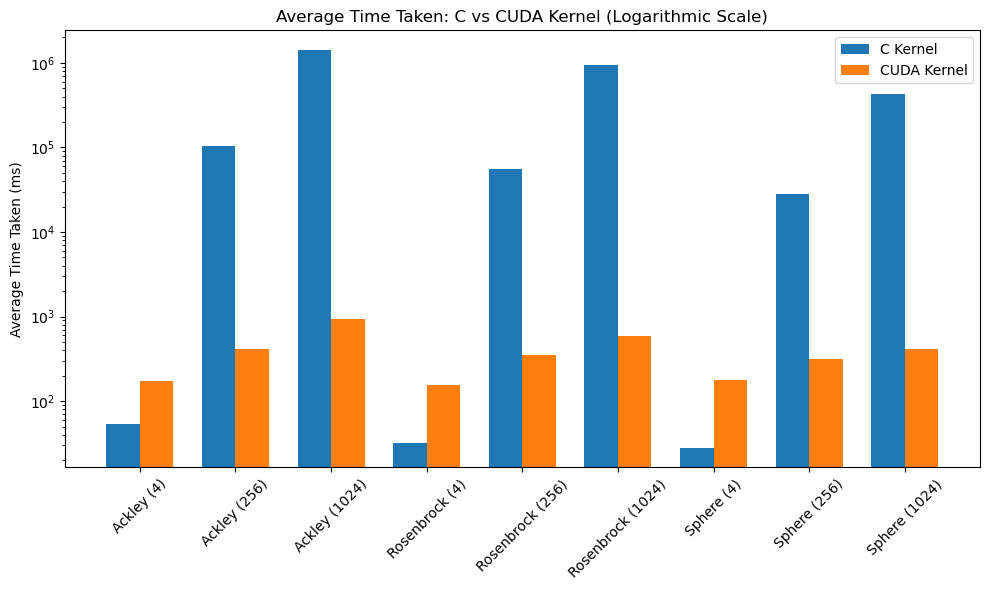

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = range(len(combined_avg_times_df))

ax.bar(x, combined_avg_times_df["Average Time Taken_C"], width, label='C Kernel')
ax.bar([i + width for i in x], combined_avg_times_df["Average Time Taken_CUDA"], width, label='CUDA Kernel')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels([f"{row['Function']} ({row['Dimension']})" for _, row in combined_avg_times_df.iterrows()], rotation=45)
ax.set_ylabel('Average Time Taken (ms)')
ax.set_title('Average Time Taken: C vs CUDA Kernel (Logarithmic Scale)')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.legend()
plt.tight_layout()
plt.show()

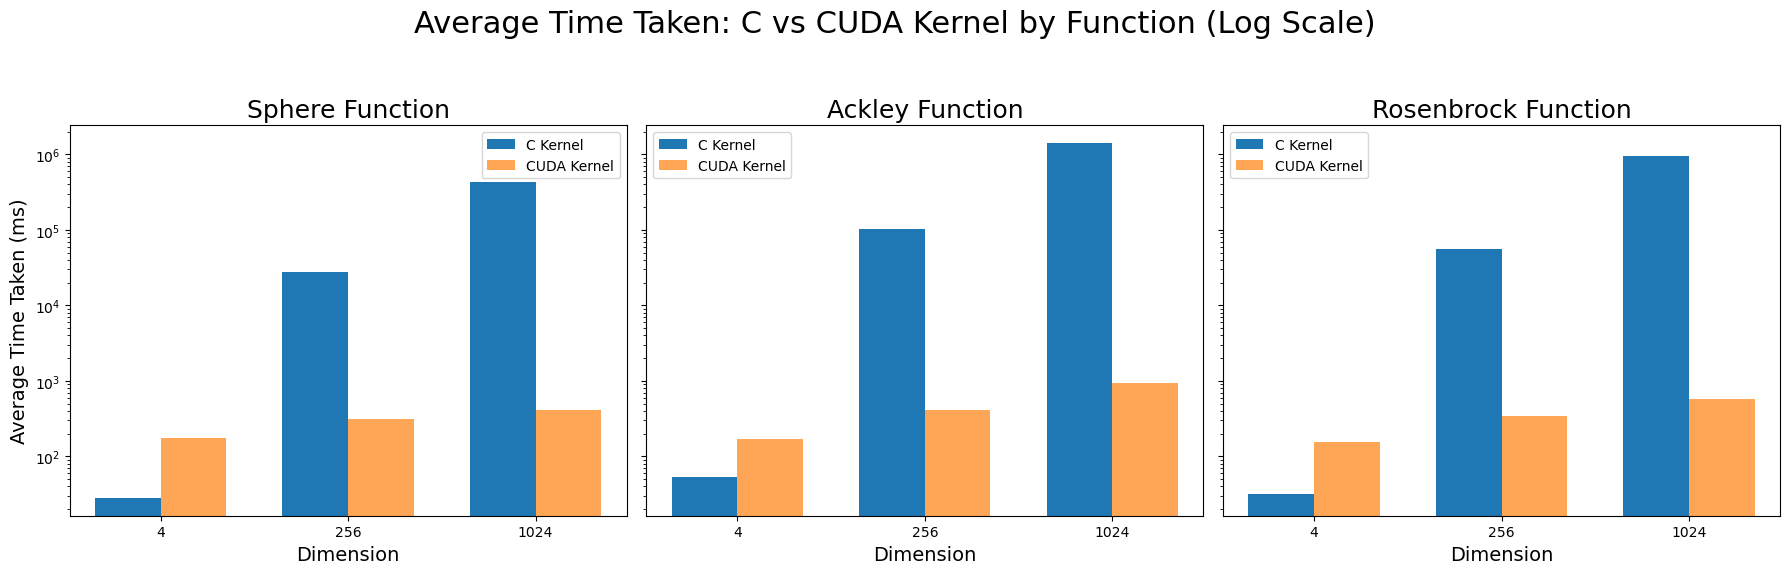

In [104]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
functions = ["Sphere", "Ackley", "Rosenbrock"]

bar_width = 0.35  # width of each bar

for i, func in enumerate(functions):
    subset = combined_avg_times_df[combined_avg_times_df["Function"] == func]

    dims = subset["Dimension"].astype(int)
    dims_str = dims.astype(str)

    x = np.arange(len(dims))  # positions for the groups

    # Side-by-side bars:
    axes[i].bar(
        x - bar_width/2,
        subset["Average Time Taken_C"],
        width=bar_width,
        label='C Kernel'
    )

    axes[i].bar(
        x + bar_width/2,
        subset["Average Time Taken_CUDA"],
        width=bar_width,
        label='CUDA Kernel',
        alpha=0.7
    )

    axes[i].set_title(f"{func} Function", fontsize=18)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(dims_str)
    axes[i].set_xlabel("Dimension", fontsize=14)
    axes[i].set_yscale('log')
    axes[i].legend()

axes[0].set_ylabel("Average Time Taken (ms)", fontsize=14)

plt.suptitle("Average Time Taken: C vs CUDA Kernel by Function (Log Scale)", fontsize=22)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])

plt.savefig("cuda_vs_c_plot.png", dpi=300)

plt.show()


Pivot DataFrame:
Function     Ackley  Rosenbrock    Sphere
Dimension                                
4            172.01     156.133   175.418
256          413.17     347.003   314.612
1024         935.90     581.780   417.693
8192       30829.70   11980.833  4849.233


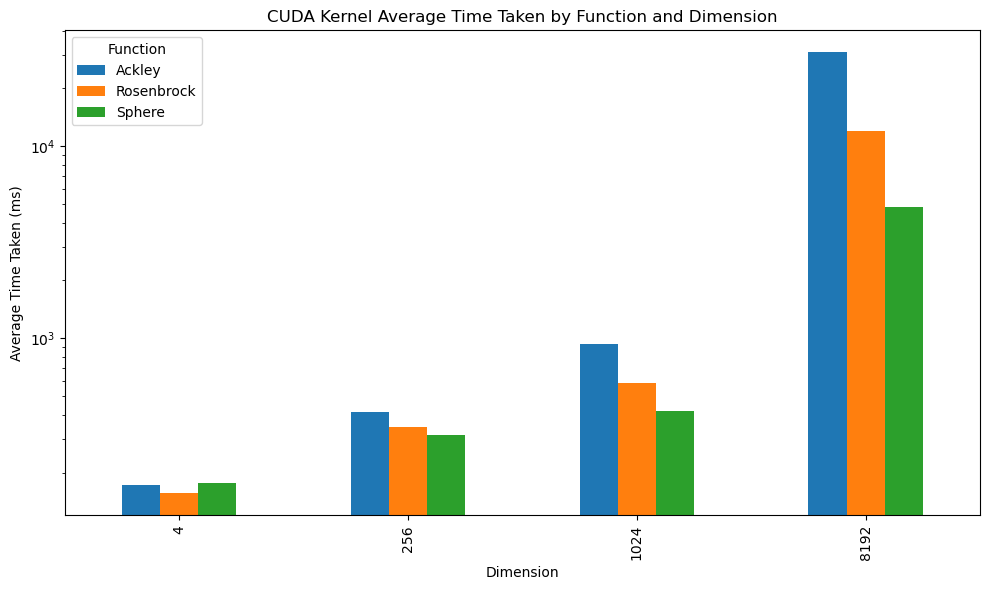

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure column names and dtypes are correct (support either ''AvgTime_MS'' or ''Average Time Taken'')
if 'Average Time Taken' not in cuda_avg_times_df.columns and 'AvgTime_MS' in cuda_avg_times_df.columns:
    cuda_avg_times_df = cuda_avg_times_df.rename(columns={'AvgTime_MS': 'Average Time Taken'})

# Convert Dimension and Average Time Taken to numeric types
cuda_avg_times_df['Dimension'] = pd.to_numeric(cuda_avg_times_df['Dimension'], errors='coerce').astype('Int64')
cuda_avg_times_df['Average Time Taken'] = pd.to_numeric(cuda_avg_times_df['Average Time Taken'], errors='coerce')

# Pivot the data: index=Dimension, columns=Function, values=Average Time Taken
pivot_df = cuda_avg_times_df.pivot(index='Dimension', columns='Function', values='Average Time Taken').sort_index()
print('Pivot DataFrame:')
print(pivot_df)

# Replace zeros with NaN to avoid plotting issues when using log scale
pivot_df = pivot_df.replace(0, np.nan)

# Plot grouped bars using pandas' plotting (which uses matplotlib under the hood)
ax = pivot_df.plot(kind='bar', figsize=(10, 6), logy=True)
ax.set_xlabel('Dimension')
ax.set_ylabel('Average Time Taken (ms)')
ax.set_title('CUDA Kernel Average Time Taken by Function and Dimension')
ax.legend(title='Function')

# Save and show the graph
plt.tight_layout()
plt.savefig('cuda_avg_times_bar_graph.png', dpi=300)
plt.show()

Pivoted Data (before reorder):
Function         Ackley               Rosenbrock                    Sphere  \
Kernel                C      CUDA              C       CUDA              C   
Dimension                                                                    
4          5.362013e+01    172.01      31.572700    156.133      28.167567   
256        1.027805e+05    413.17   55871.931967    347.003   28049.122633   
1024       1.411232e+06    935.90  937610.296867    581.780  425413.873600   
8192                NaN  30829.70            NaN  11980.833            NaN   

Function             
Kernel         CUDA  
Dimension            
4           175.418  
256         314.612  
1024        417.693  
8192       4849.233  

Pivoted Data (after reorder):
Function         Ackley     Rosenbrock         Sphere    Ackley Rosenbrock  \
Kernel                C              C              C      CUDA       CUDA   
Dimension                                                                    
4  

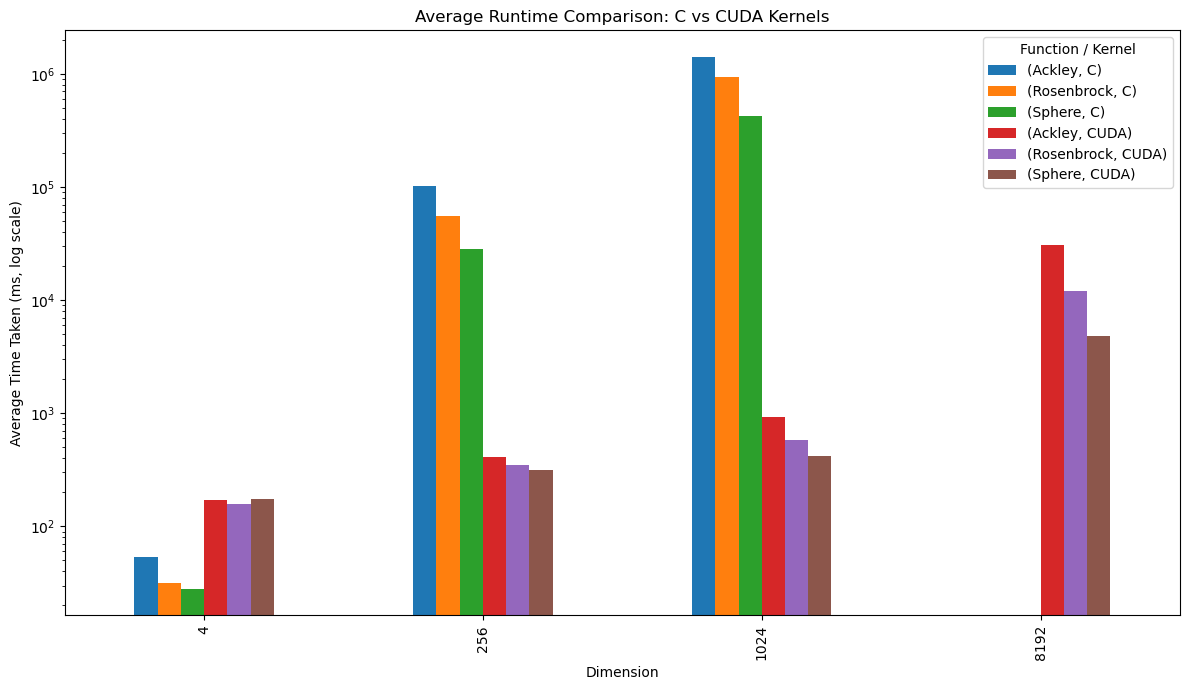

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Use merged_avg_times_df directly ---
df = merged_avg_times_df.copy()

# Ensure numeric dtypes
df['Dimension'] = pd.to_numeric(df['Dimension'], errors='coerce').astype('Int64')
df['Average Time Taken'] = pd.to_numeric(df['Average Time Taken'], errors='coerce')

# Pivot so rows = Dimension, columns = (Function, Kernel)
pivot_df = df.pivot_table(
    index='Dimension',
    columns=['Function', 'Kernel'],
    values='Average Time Taken'
).sort_index()

print("Pivoted Data (before reorder):")
print(pivot_df)

# ---- NEW: reorder columns so C comes before CUDA ----
new_cols = []

# Functions sorted alphabetically (or by order of appearance)
functions = pivot_df.columns.levels[0]
for func in functions:
    if (func, "C") in pivot_df.columns:
        new_cols.append((func, "C"))
    if (func, "CUDA") in pivot_df.columns:
        new_cols.append((func, "CUDA"))

pivot_df = pivot_df[new_cols]

# ---- NEW: reorder columns so ALL C columns come first, then ALL CUDA columns ----
c_cols = [col for col in pivot_df.columns if col[1] == "C"]
cuda_cols = [col for col in pivot_df.columns if col[1] == "CUDA"]

new_cols = c_cols + cuda_cols
pivot_df = pivot_df[new_cols]


print("\nPivoted Data (after reorder):")
print(pivot_df)

# Replace zeros with NaN for log scale compatibility
pivot_df = pivot_df.replace(0, np.nan)

# Plot
ax = pivot_df.plot(
    kind='bar',
    figsize=(12, 7),
    logy=True
)

ax.set_xlabel("Dimension")
ax.set_ylabel("Average Time Taken (ms, log scale)")
ax.set_title("Average Runtime Comparison: C vs CUDA Kernels")
plt.legend(title="Function / Kernel")
plt.tight_layout()
plt.savefig("c_vs_cuda_avg_times.png", dpi=300)
plt.show()
